## Load and unzip weatherdata

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pandas import read_csv

import features_engineering as fe
from cleaning import interpolate_time_series, clean_trace_and_convert
from config import WEATHER_FEATURES_TO_IMPUTE, WEATHER_COLUMNS_TO_DROP, \
  WEATHER_PATH, \
  WEATHER_RAW_PATH
from data_loader import load_weather_data


/Users/Wendo99/miniconda3/envs/NYC_Taxi/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
weather_data_raw = load_weather_data()

In [3]:
weather_data_new_rows = read_csv('gitData/weather_data_new_rows.csv')

In [4]:
# Merge weather data
weather_data_raw = pd.concat([weather_data_raw, weather_data_new_rows])
weather_data_raw_copy = weather_data_raw.copy()
weather_data = fe.add_weather_time_features(weather_data_raw)

# EDA  weather_data

## General EDA

In [5]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5334 entries, 0 to 158
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   timestamp      5334 non-null   object        
 1   temp           5334 non-null   float64       
 2   windspeed      4195 non-null   float64       
 3   humidity       5334 non-null   float64       
 4   precip         5334 non-null   float64       
 5   pressure       5200 non-null   float64       
 6   conditions     5334 non-null   object        
 7   dailyprecip    5334 non-null   object        
 8   dailysnow      5334 non-null   object        
 9   fog            5334 non-null   int64         
 10  rain           5334 non-null   int64         
 11  snow           5334 non-null   int64         
 12  datetime       5334 non-null   datetime64[ns]
 13  datetime_hour  5334 non-null   datetime64[ns]
 14  hour_of_day    5334 non-null   int32         
 15  hour_of_year   5334 non-nul

In [6]:
weather_data.duplicated().sum()

np.int64(0)

- timestamp into datetime
- temp into celsius
- windspeed into kph
- precip into mm
- pressure into hpa
- dailyprecip into mm
- dailysnow into mm

In [7]:
weather_data.describe()

,temp,windspeed,humidity,precip,pressure,fog,rain,snow,datetime,datetime_hour,hour_of_day,hour_of_year
count,5334.000000,4195.000000,5334.000000,5334.000000,5200.000000,5334.000000,5334.000000,5334.000000,5334,5334,5334.000000,5334.000000
mean,51.095726,7.388272,58.662917,0.007355,29.972810,0.008999,0.083615,0.037308,2016-04-02 01:52:14.983127040,2016-04-02 01:05:01.012373504,11.333333,2209.083615
min,-0.900000,0.000000,9.000000,0.000000,29.220000,0.000000,0.000000,0.000000,2016-01-01 00:51:00,2016-01-01 00:00:00,0.000000,0.000000
25%,39.000000,4.600000,43.000000,0.000000,29.810000,0.000000,0.000000,0.000000,2016-02-16 07:59:30,2016-02-16 07:15:00,5.000000,1111.250000
50%,51.100000,6.900000,56.000000,0.000000,29.980000,0.000000,0.000000,0.000000,2016-04-01 20:21:00,2016-04-01 19:30:00,11.000000,2203.500000
75%,64.000000,9.200000,78.000000,0.000000,30.130000,0.000000,0.000000,0.000000,2016-05-16 02:29:30,2016-05-16 02:00:00,17.000000,3266.000000
max,90.000000,85.200000,100.000000,0.730000,30.620000,1.000000,1.000000,1.000000,2016-07-01 23:51:00,2016-07-01 23:00:00,23.000000,4391.000000
std,15.997815,3.982570,20.813630,0.035540,0.235095,0.094443,0.276835,0.189533,NaN,NaN,6.862412,1259.867692


In [8]:
weather_data.describe(include='object')

,timestamp,conditions,dailyprecip,dailysnow
count,5334,5334,5334,5334
unique,5329,23,41,11
top,2016-04-04 02:51:00,Clear,0.00,0.00
freq,2,2238,2577,4491


- timestamp has one double

In [9]:
weather_data.nunique()

timestamp        5329
temp              145
windspeed          44
humidity           89
precip             42
pressure          140
conditions         23
dailyprecip        41
dailysnow          11
fog                 2
rain                2
snow                2
datetime         5329
datetime_hour    4392
hour_of_day        24
hour_of_year     4392
dtype: int64

## EDA timestamp (datetime)

In [10]:
# Check for format consistency
weather_data['datetime_hour'].astype(str).str.match(
    r'^\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}$').all()

np.True_

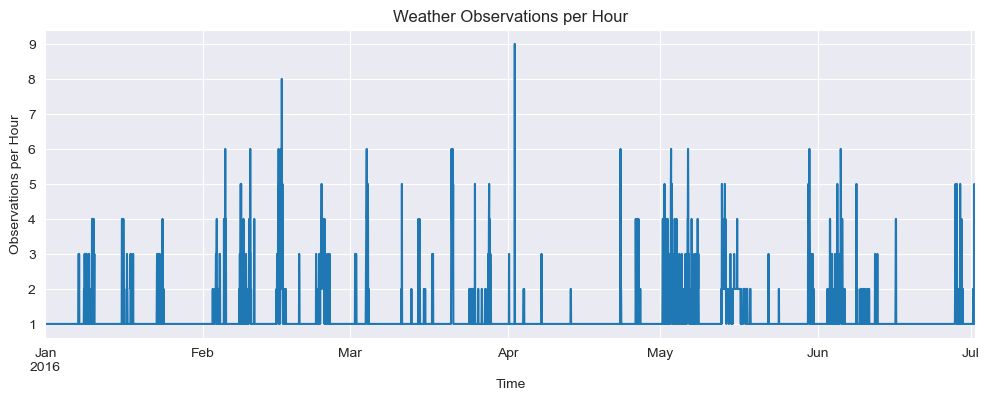

In [11]:
counts_per_hour = weather_data['datetime_hour'].value_counts().sort_index()

# Plot time series frequency
plt.figure(figsize=(12, 4))
counts_per_hour.plot()
plt.title("Weather Observations per Hour")
plt.xlabel("Time")
plt.ylabel("Observations per Hour")
plt.grid(True)
plt.show()

- The timestamps are predominantly distributed hourly, with slight fluctuations.
- There are some dips in frequency; potentially missing hours.
- The data does not appear to be exactly on the hour (e.g. xx:51).

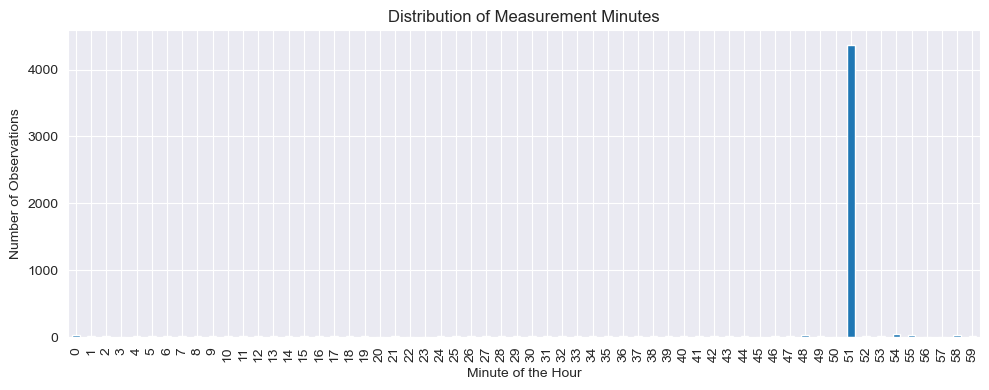

In [12]:
# Extract minute component from timestamp
weather_data['datetime_minute'] = weather_data['datetime'].dt.minute

# Count how many records fall into each minute of the hour
minute_distribution = weather_data['datetime_minute'].value_counts().sort_index()

# Plot the distribution of measurement minutes
plt.figure(figsize=(10, 4))
minute_distribution.plot(kind='bar')
plt.title("Distribution of Measurement Minutes")
plt.xlabel("Minute of the Hour")
plt.ylabel("Number of Observations")
plt.grid(True)
plt.tight_layout()
plt.show()

- Minute 51 is by far the most frequent minute of measurement (over 4000 entries).
- All other minutes are rare or sporadic → probably exceptions, manual additions or other sources.

In [13]:
weather_data['datetime_hour'] = weather_data['datetime'].dt.floor('h')

In [14]:
# Aggregate to hourly level using mean for continuous values, max for binary flags
weather_data = fe.aggregate_weather_hourly(weather_data)

In [15]:
weather_data = fe.add_weather_time_features(weather_data, timestamp_col='datetime_hour')
weather_data = clean_trace_and_convert(weather_data, ['dailyprecip', 'dailysnow'])

In [16]:
# Standardizes units of measurement & classifies all weather phenomena
weather_data = fe.add_weather_features(weather_data)

In [17]:
cols_to_drop = WEATHER_COLUMNS_TO_DROP

weather_data.drop(columns=[col for col in WEATHER_COLUMNS_TO_DROP if col in weather_data.columns],
                  inplace=True)

- Exactly one timestamp is duplicated: 2016-03-13 00:51:00; Two different entries (Clear vs. Light
Rain), probably two weather sources or measurements.

## EDA temp

In [18]:
weather_data['temp_c'].describe()

count    4392.000000
mean       10.728907
std         9.158675
min       -18.277778
25%         3.888889
50%        10.611111
75%        17.777778
max        32.222222
Name: temp_c, dtype: float64

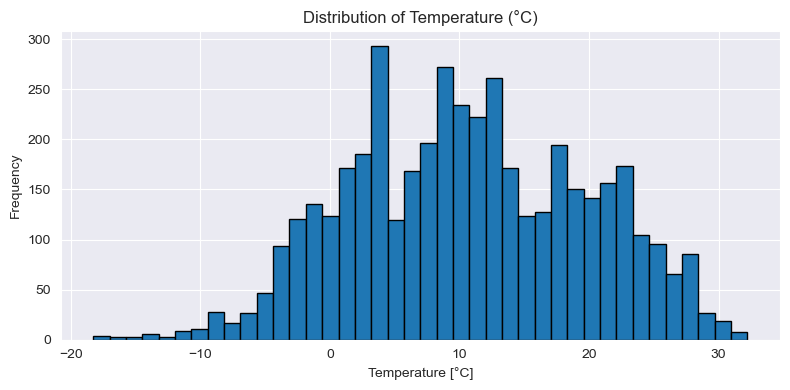

In [19]:
plt.figure(figsize=(8, 4))
weather_data['temp_c'].plot.hist(bins=40, edgecolor='black')
plt.title('Distribution of Temperature (°C)')
plt.xlabel("Temperature [°C]")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

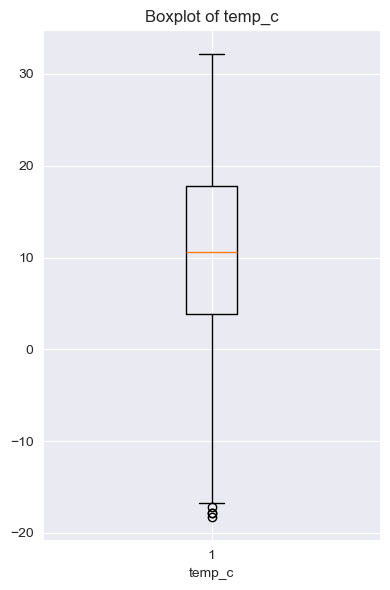

In [20]:
plt.figure(figsize=(4, 6))
plt.boxplot(weather_data["temp_c"].dropna())
plt.title("Boxplot of temp_c")
plt.xlabel("temp_c")
plt.tight_layout()
plt.show()

## EDA Windspeed

In [21]:
weather_data['windspeed_kph'].describe()

count    3542.000000
mean       11.689335
std         6.379921
min         0.000000
25%         7.402964
50%        11.104446
75%        14.805928
max       137.115768
Name: windspeed_kph, dtype: float64

In [22]:
weather_data['windspeed_kph'].isna().sum()

np.int64(850)

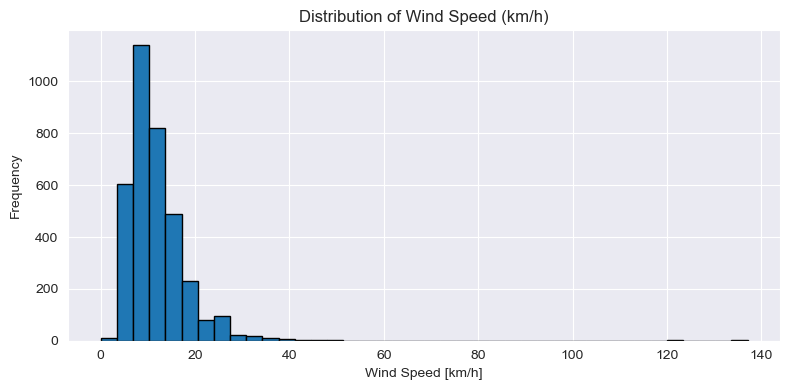

In [23]:
plt.figure(figsize=(8, 4))
weather_data['windspeed_kph'].plot.hist(bins=40, edgecolor='black')
plt.title("Distribution of Wind Speed (km/h)")
plt.xlabel("Wind Speed [km/h]")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

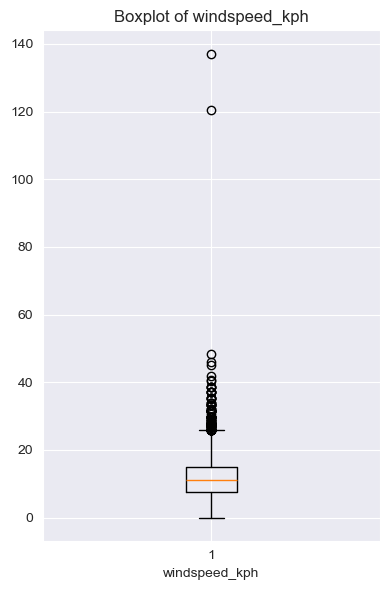

In [24]:
plt.figure(figsize=(4, 6))
plt.boxplot(weather_data["windspeed_kph"].dropna())
plt.title("Boxplot of windspeed_kph")
plt.xlabel("windspeed_kph")
plt.tight_layout()
plt.show()

- Most values lie between 5 and 25 km/h, which is typical for city-level weather.
- One extremely high value (137.12 km/h) may be an outlier.
- The variable appears well-behaved and usable without further transformation.

## EDA humidity

In [25]:
weather_data['humidity'].describe()

count    4392.000000
mean       54.144423
std        18.964341
min         9.000000
25%        40.000000
50%        51.000000
75%        67.125000
max       100.000000
Name: humidity, dtype: float64

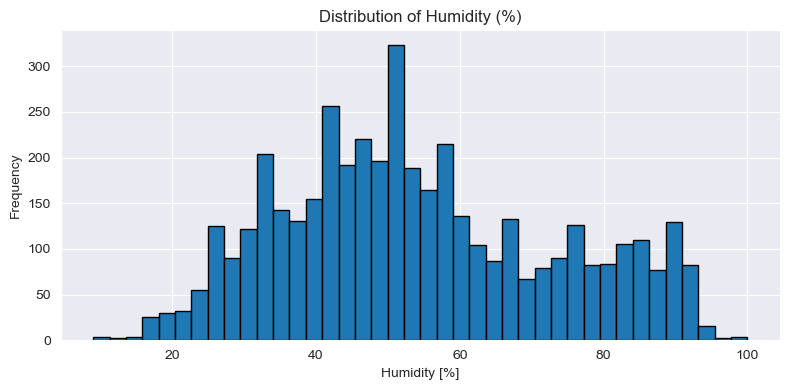

In [26]:
plt.figure(figsize=(8, 4))
weather_data['humidity'].plot.hist(bins=40, edgecolor='black')
plt.title("Distribution of Humidity (%)")
plt.xlabel("Humidity [%]")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

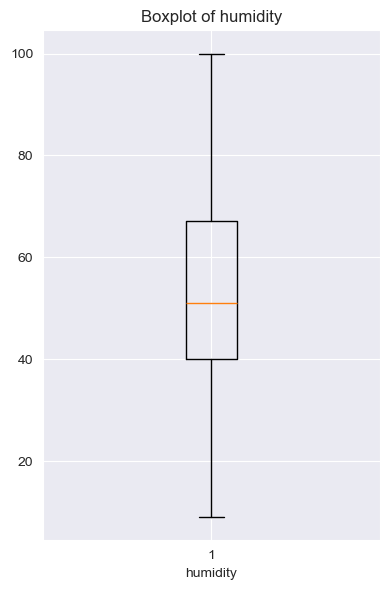

In [27]:
plt.figure(figsize=(4, 6))
plt.boxplot(weather_data["humidity"].dropna())
plt.title("Boxplot of humidity")
plt.xlabel("humidity")
plt.tight_layout()
plt.show()

- Values range from 9% to 97%.
- Most values lie between 40% and 70%.
- No anomalies or unrealistic entries.

## EDA precip

In [28]:
weather_data['precip_mm'].describe()

count    4392.000000
mean        0.226877
std         1.792190
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        46.990000
Name: precip_mm, dtype: float64

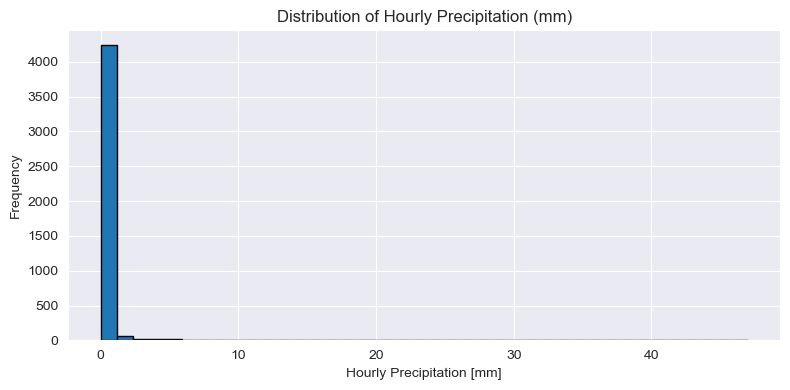

In [29]:
plt.figure(figsize=(8, 4))
weather_data['precip_mm'].plot.hist(bins=40, edgecolor='black')
plt.title("Distribution of Hourly Precipitation (mm)")
plt.xlabel("Hourly Precipitation [mm]")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

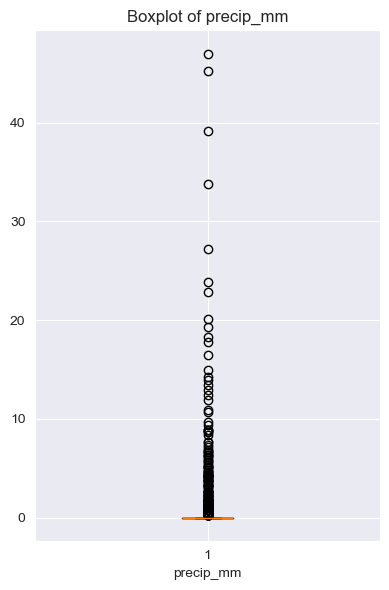

In [30]:
plt.figure(figsize=(4, 6))
plt.boxplot(weather_data["precip_mm"].dropna())
plt.title("Boxplot of precip_mm")
plt.xlabel("precip_mm")
plt.tight_layout()
plt.show()

Findings of the Exploration
- Most values are 0.0 (dry hours).
- Occasional rain events up to 18.5 mm.

Required Arrangements
- None. Consider binary flag creation (e.g. had_rain = precip_mm > 0).

## EDA pressure

In [31]:
weather_data['pressure_hPa'].describe()

count    4361.000000
mean     1015.640291
std         7.900185
min       989.841797
25%      1010.160137
50%      1015.917000
75%      1020.657946
max      1036.912618
Name: pressure_hPa, dtype: float64

In [32]:
weather_data['pressure_hPa'].isna().sum()

np.int64(31)

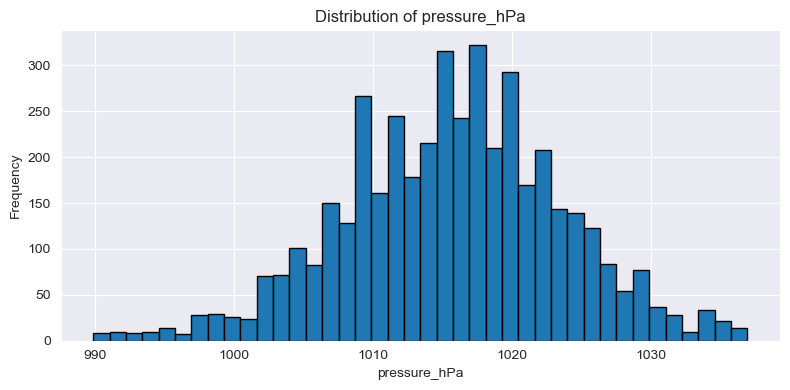

In [33]:
plt.figure(figsize=(8, 4))
weather_data['pressure_hPa'].plot.hist(bins=40, edgecolor='black')
plt.title("Distribution of pressure_hPa")
plt.xlabel("pressure_hPa")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

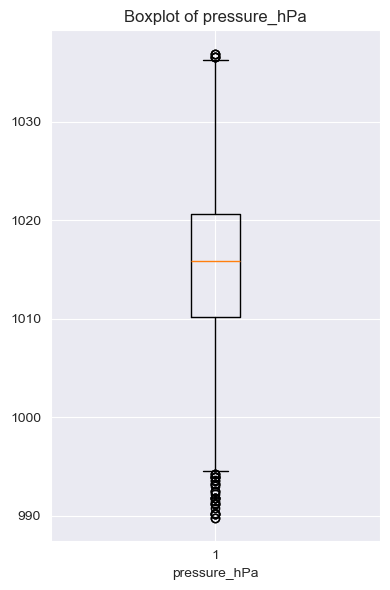

In [34]:
plt.figure(figsize=(4, 6))
plt.boxplot(weather_data["pressure_hPa"].dropna())
plt.title("Boxplot of pressure_hPa")
plt.xlabel("pressure_hPa")
plt.tight_layout()
plt.show()

## EDA dailyrain

In [35]:
weather_data['precip_daily_mm'].value_counts()

precip_daily_mm
0.0000     2515
0.0254      474
0.2540      185
1.2700       96
1.0160       96
2.2860       94
0.5080       72
4.0640       72
6.0960       48
11.4300      48
1.5240       48
5.5880       24
23.1140      24
10.1600      24
9.6520       24
4.5720       24
13.7160      24
15.4940      24
5.0800       24
3.0480       24
41.9100      24
1.7780       24
21.0820      24
58.6740      24
2.7940       24
3.5560       24
30.9880      24
7.6200       24
45.7200      24
7.3660       24
0.7620       24
25.6540      24
11.1760      24
13.4620      24
18.5420      24
11.9380      23
3.8100       21
6.3500       20
12.7000       4
Name: count, dtype: int64

In [36]:
weather_data['precip_daily_mm'].isna().sum()

np.int64(0)

In [37]:
weather_data['precip_daily_mm'].describe()

count    4392.000000
mean        2.601441
std         7.675330
min         0.000000
25%         0.000000
50%         0.000000
75%         1.016000
max        58.674000
Name: precip_daily_mm, dtype: float64

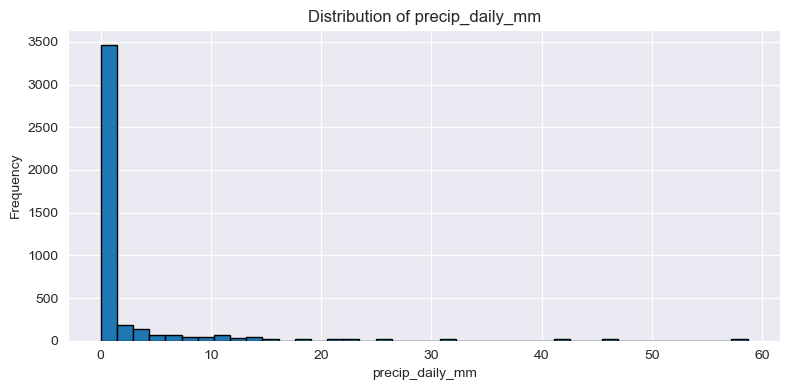

In [38]:
plt.figure(figsize=(8, 4))
weather_data['precip_daily_mm'].plot.hist(bins=40, edgecolor='black')
plt.title("Distribution of precip_daily_mm")
plt.xlabel("precip_daily_mm")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

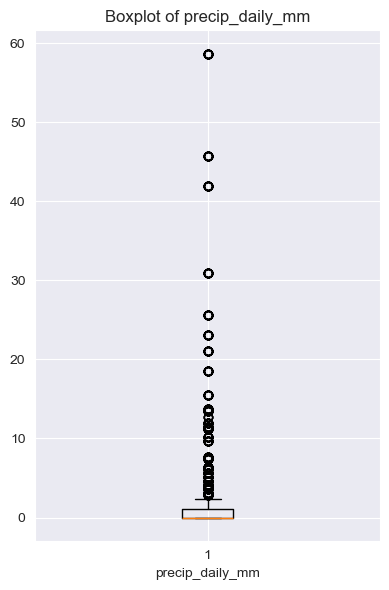

In [39]:
plt.figure(figsize=(4, 6))
plt.boxplot(weather_data["precip_daily_mm"].dropna())
plt.title("Boxplot of precip_daily_mm")
plt.xlabel("precip_daily_mm")
plt.tight_layout()
plt.show()

- ...

## EDA dailysnow

In [40]:
weather_data['daily_snow_mm'].value_counts()

daily_snow_mm
0.0000      3915
0.0254       285
10.1600       48
5.0800        24
675.6400      24
63.5000       24
2.5400        24
35.5600       24
12.7000       24
Name: count, dtype: int64

In [41]:
weather_data['daily_snow_mm'].describe()

count    4392.000000
mean        4.457058
std        50.063088
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       675.640000
Name: daily_snow_mm, dtype: float64

In [42]:
weather_data['daily_snow_mm'].isna().sum()

np.int64(0)

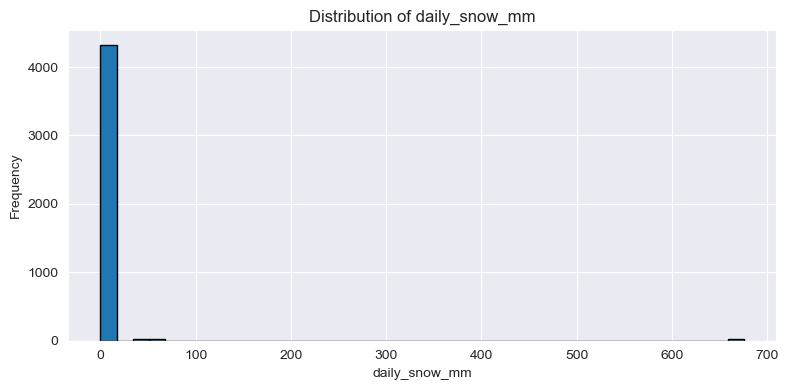

In [43]:
plt.figure(figsize=(8, 4))
weather_data['daily_snow_mm'].plot.hist(bins=40, edgecolor='black')
plt.title("Distribution of daily_snow_mm")
plt.xlabel("daily_snow_mm")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

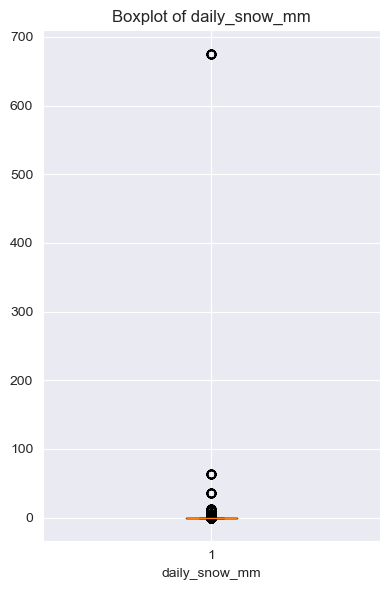

In [44]:
plt.figure(figsize=(4, 6))
plt.boxplot(weather_data["daily_snow_mm"].dropna())
plt.title("Boxplot of daily_snow_mm")
plt.xlabel("daily_snow_mm")
plt.tight_layout()
plt.show()

EDA fog, rain, snow

In [45]:
weather_data['fog'].value_counts()

fog
0    4361
1      31
Name: count, dtype: int64

In [46]:
weather_data['rain'].value_counts()

rain
0    4170
1     222
Name: count, dtype: int64

In [47]:
weather_data['snow'].value_counts()

snow
0    4313
1      79
Name: count, dtype: int64

## EDA Conditions

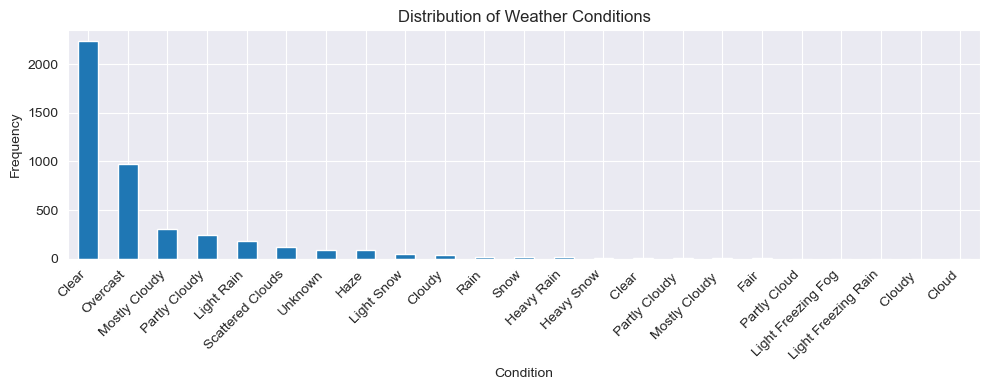

In [48]:
condition_counts = weather_data['conditions'].value_counts()

plt.figure(figsize=(10, 4))
condition_counts.plot(kind='bar')
plt.title("Distribution of Weather Conditions")
plt.xlabel("Condition")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

- Most common condition is Clear (2215 times), followed by Overcast (1000).
- Some conditions occur only a few times, e.g., Heavy Snow, Light Freezing Fog.
- Unknown appears 83 times and may indicate missing or invalid sensor data.

# Imputation

In [49]:
weather_data_before_imputation = weather_data

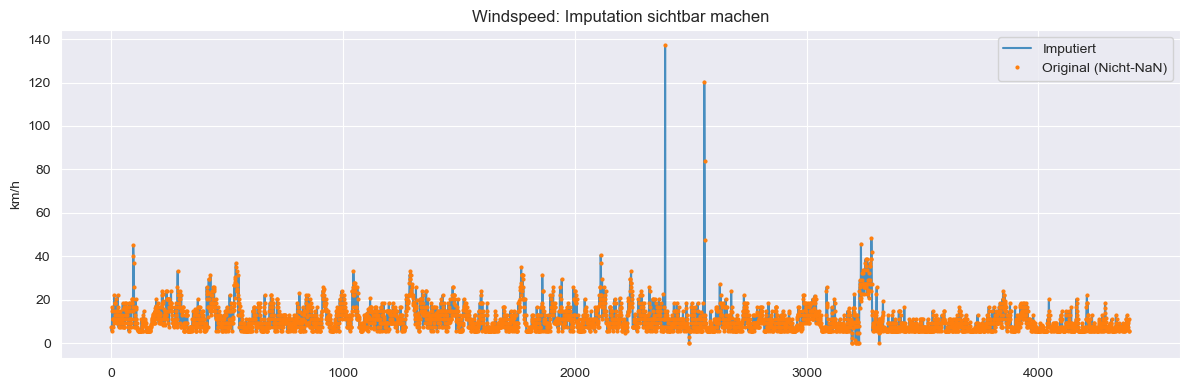

In [50]:
weather_data = interpolate_time_series(weather_data, WEATHER_FEATURES_TO_IMPUTE)

plt.figure(figsize=(12, 4))
weather_data['windspeed_kph'].plot(label='Imputiert', alpha=0.8)
weather_data['windspeed_kph'].where(weather_data['windspeed_kph'].notna()).plot(
    style='o',
    label='Original (Nicht-NaN)',
    markersize=2)
plt.title('Windspeed: Imputation sichtbar machen')
plt.ylabel('km/h')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [51]:
before = weather_data_before_imputation['windspeed_kph']
after = weather_data['windspeed_kph']

print("mean before:", before.mean())
print("mean after:", after.mean())
print("std deviation before:", before.std())
print("std deviation after:", after.std())

mean before: 11.689334705057673
mean after: 11.046007094257957
std deviation before: 6.379921320492424
std deviation after: 6.152144883188492


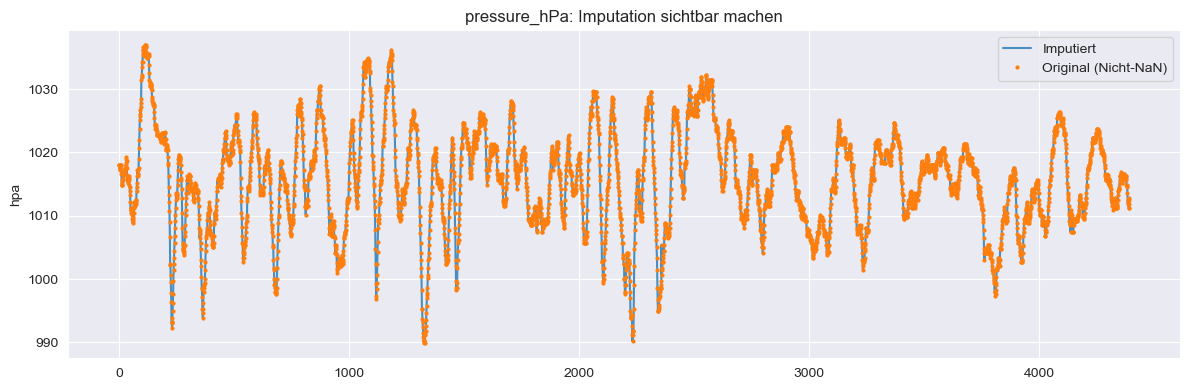

In [52]:
weather_data_before_imputation = weather_data

plt.figure(figsize=(12, 4))
weather_data['pressure_hPa'].plot(label='Imputiert', alpha=0.8)
weather_data['pressure_hPa'].where(weather_data['pressure_hPa'].notna()).plot(style='o',
                                                                              label='Original (Nicht-NaN)',
                                                                              markersize=2)
plt.title('pressure_hPa: Imputation sichtbar machen')
plt.ylabel('hpa')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [53]:
before = weather_data_before_imputation['pressure_hPa']
after = weather_data['pressure_hPa']

print("mean before:", before.mean())
print("mean after:", after.mean())
print("std deviation before:", before.std())
print("std deviation after:", after.std())

mean before: 1015.6767479746428
mean after: 1015.6767479746428
std deviation before: 7.8857469272456
std deviation after: 7.8857469272456


In [54]:
fe.classify_windspeed(weather_data)
fe.classify_pressure(weather_data)
weather_data.isna().sum()

datetime_hour      0
humidity           0
fog                0
rain               0
snow               0
conditions         0
datetime           0
hour_of_day        0
hour_of_year       0
temp_c             0
windspeed_kph      0
precip_mm          0
pressure_hPa       0
precip_daily_mm    0
daily_snow_mm      0
rain_class         0
rain_code          0
snow_class         0
snow_code          0
cloud_class        0
cloud_code         0
hazy_class         0
hazy_code          0
freezing_class     0
freezing_code      0
fog_class          0
fog_code           0
temp_class         0
temp_code          0
windspeed_class    0
windspeed_code     0
humidity_class     0
humidity_code      0
pressure_class     0
pressure_code      0
dtype: int64

In [55]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4392 entries, 0 to 4391
Data columns (total 35 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   datetime_hour    4392 non-null   datetime64[ns]
 1   humidity         4392 non-null   float64       
 2   fog              4392 non-null   int64         
 3   rain             4392 non-null   int64         
 4   snow             4392 non-null   int64         
 5   conditions       4392 non-null   object        
 6   datetime         4392 non-null   datetime64[ns]
 7   hour_of_day      4392 non-null   int32         
 8   hour_of_year     4392 non-null   int32         
 9   temp_c           4392 non-null   float64       
 10  windspeed_kph    4392 non-null   float64       
 11  precip_mm        4392 non-null   float64       
 12  pressure_hPa     4392 non-null   float64       
 13  precip_daily_mm  4392 non-null   float64       
 14  daily_snow_mm    4392 non-null   float64

# Classify / EDA  Weather Conditions

## Classify / EDA –  rain intensity

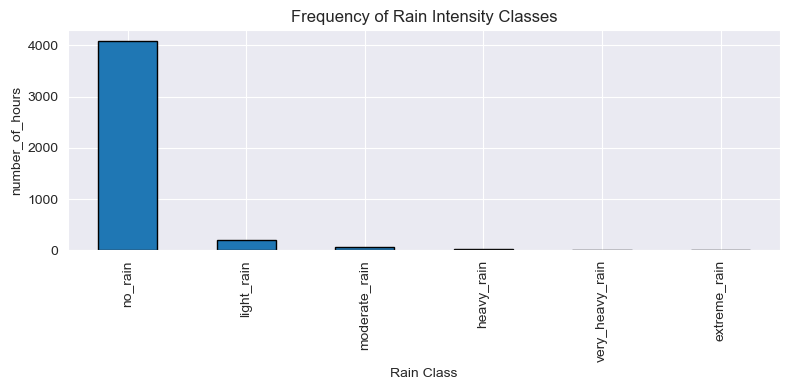

In [56]:
rain_counts = weather_data['rain_class'].value_counts().reindex([
  'no_rain', 'light_rain', 'moderate_rain', 'heavy_rain', 'very_heavy_rain', 'extreme_rain'
])

rain_counts.plot(kind='bar', edgecolor='black', figsize=(8, 4))
plt.title("Frequency of Rain Intensity Classes")
plt.xlabel("Rain Class")
plt.ylabel('number_of_hours')
plt.grid(True)
plt.tight_layout()
plt.show()

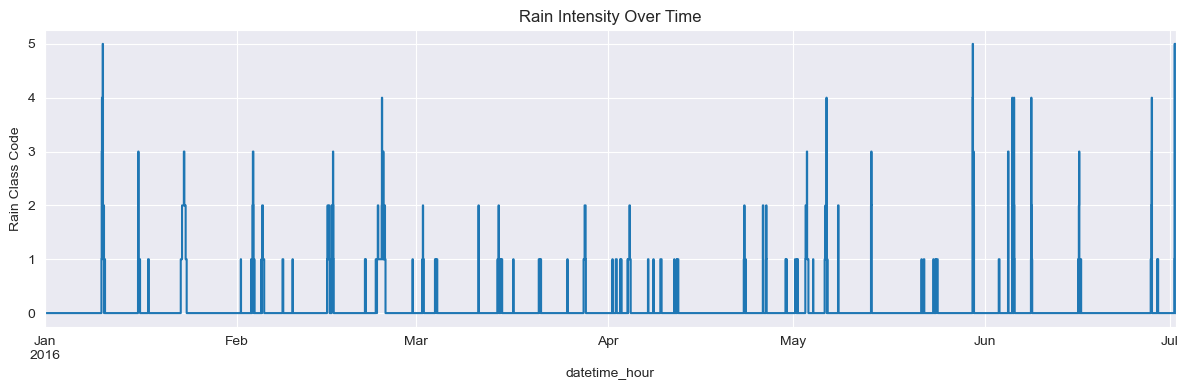

In [57]:
rain_time_series = weather_data.set_index('datetime_hour')['rain_code']

plt.figure(figsize=(12, 4))
rain_time_series.plot(drawstyle='steps-post')
plt.title("Rain Intensity Over Time")
plt.ylabel("Rain Class Code")
plt.grid(True)
plt.tight_layout()
plt.show()

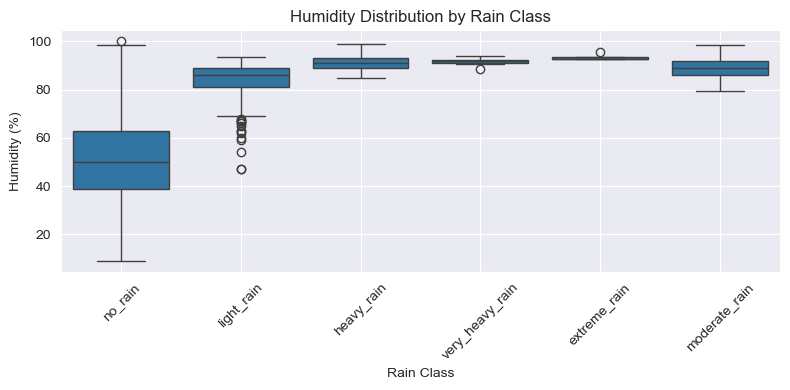

In [58]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=weather_data, x='rain_class', y='humidity')
plt.title("Humidity Distribution by Rain Class")
plt.xlabel("Rain Class")
plt.ylabel("Humidity (%)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

## Classify / EDA – snow intensity

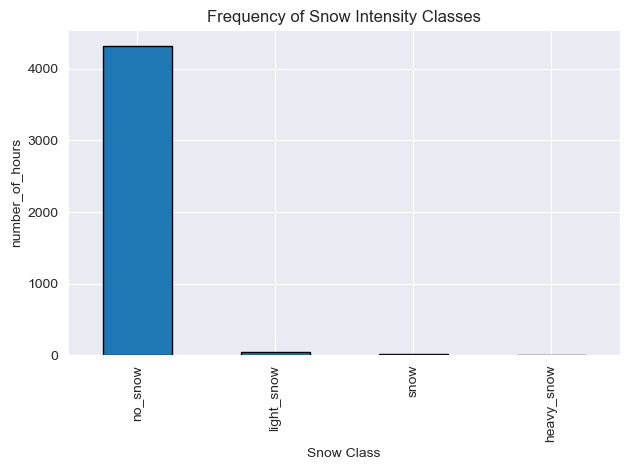

In [59]:
weather_data['snow_class'].value_counts().reindex([
  'no_snow', 'light_snow', "snow", 'heavy_snow'
]).plot(kind='bar', edgecolor='black')
plt.title("Frequency of Snow Intensity Classes")
plt.xlabel("Snow Class")
plt.ylabel('number_of_hours')
plt.grid(True)
plt.tight_layout()
plt.show()

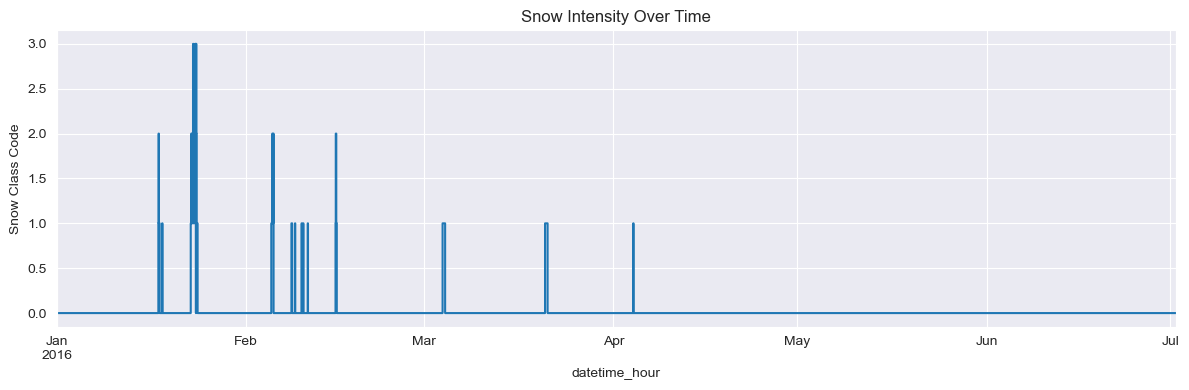

In [60]:
# Time series: Snow Class Code
plt.figure(figsize=(12, 4))
weather_data.set_index('datetime_hour')['snow_code'].plot(drawstyle='steps-post')
plt.title("Snow Intensity Over Time")
plt.ylabel("Snow Class Code")
plt.grid(True)
plt.tight_layout()
plt.show()

## Classify / EDA –  cloud intensity

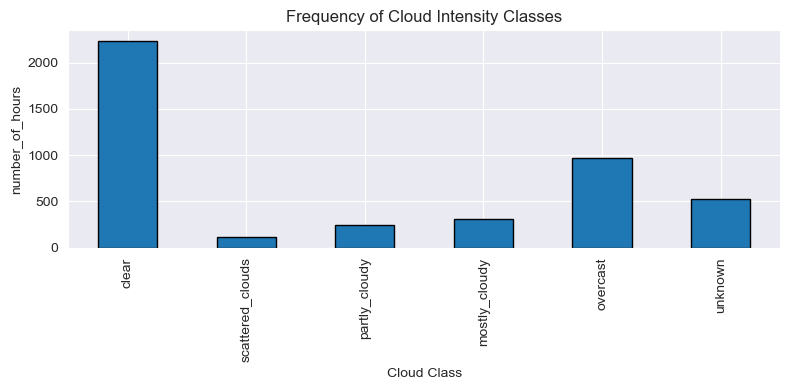

In [61]:
# Bar plot: Frequency of Cloud Classes
cloud_counts = weather_data['cloud_class'].value_counts().reindex([
  "clear", 'scattered_clouds', 'partly_cloudy', 'mostly_cloudy', "overcast", "unknown"
])
cloud_counts.plot(kind='bar', edgecolor='black', figsize=(8, 4))
plt.title("Frequency of Cloud Intensity Classes")
plt.xlabel("Cloud Class")
plt.ylabel('number_of_hours')
plt.grid(True)
plt.tight_layout()
plt.show()

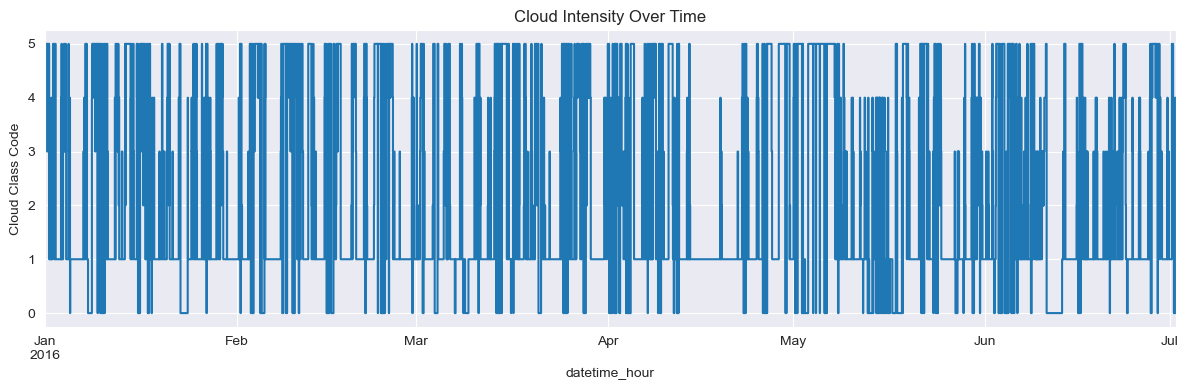

In [62]:
# Time series: Cloud Class Code
plt.figure(figsize=(12, 4))
weather_data.set_index('datetime_hour')['cloud_code'].plot(drawstyle='steps-post')
plt.title("Cloud Intensity Over Time")
plt.ylabel("Cloud Class Code")
plt.grid(True)
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Humidity by Cloud Class')

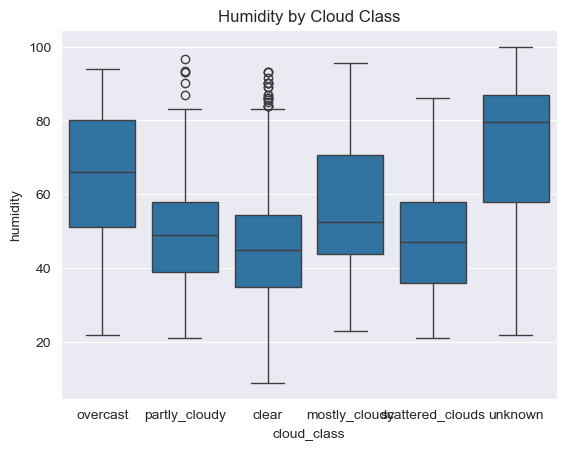

In [63]:
sns.boxplot(data=weather_data, x='cloud_class', y='humidity')
plt.title("Humidity by Cloud Class")

## Classify / EDA –  haze intensity

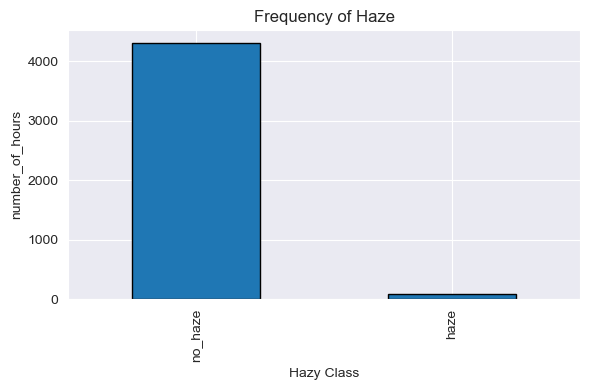

In [64]:
# Bar plot: Frequency of Haze
hazy_counts = weather_data['hazy_class'].value_counts().reindex(['no_haze', "haze"])
hazy_counts.plot(kind='bar', edgecolor='black', figsize=(6, 4))
plt.title("Frequency of Haze")
plt.xlabel("Hazy Class")
plt.ylabel('number_of_hours')
plt.grid(True)
plt.tight_layout()
plt.show()

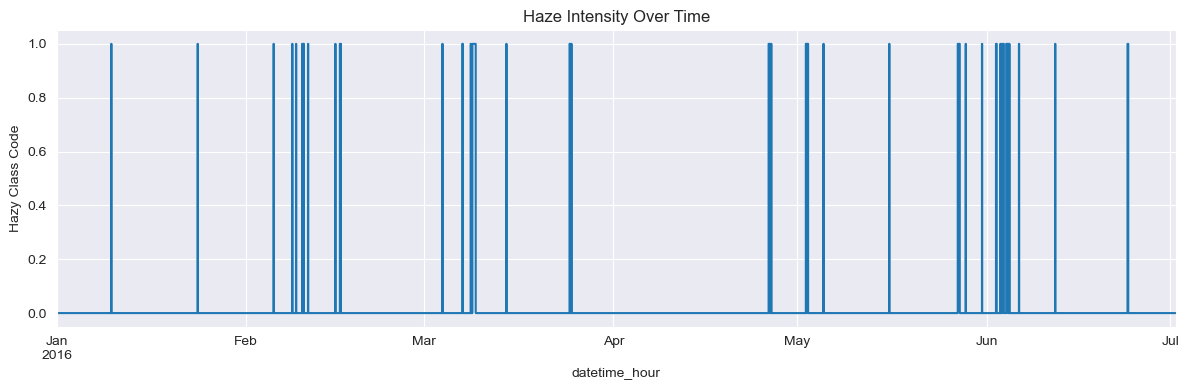

In [65]:
# Time series: Hazy Class Code
plt.figure(figsize=(12, 4))
weather_data.set_index('datetime_hour')['hazy_code'].plot(drawstyle='steps-post')
plt.title("Haze Intensity Over Time")
plt.ylabel("Hazy Class Code")
plt.grid(True)
plt.tight_layout()
plt.show()

## Classify / EDA –  freezing fog or rain

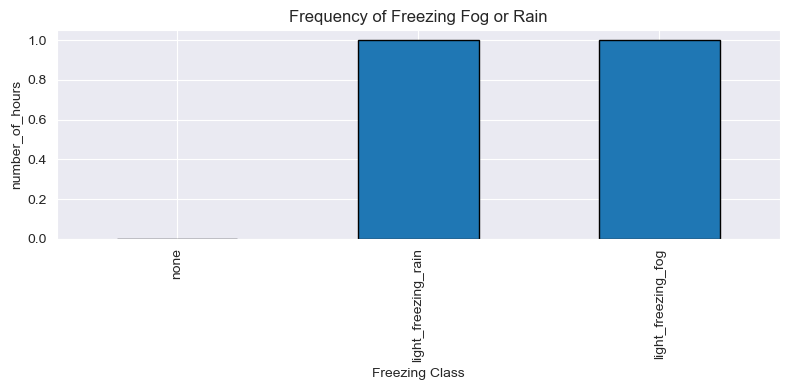

In [66]:
# Bar plot: Frequency of Freezing Classes
freezing_counts = weather_data['freezing_class'].value_counts().reindex([
  "none", 'light_freezing_rain', 'light_freezing_fog'
])
freezing_counts.plot(kind='bar', edgecolor='black', figsize=(8, 4))
plt.title("Frequency of Freezing Fog or Rain")
plt.xlabel("Freezing Class")
plt.ylabel('number_of_hours')
plt.grid(True)
plt.tight_layout()
plt.show()

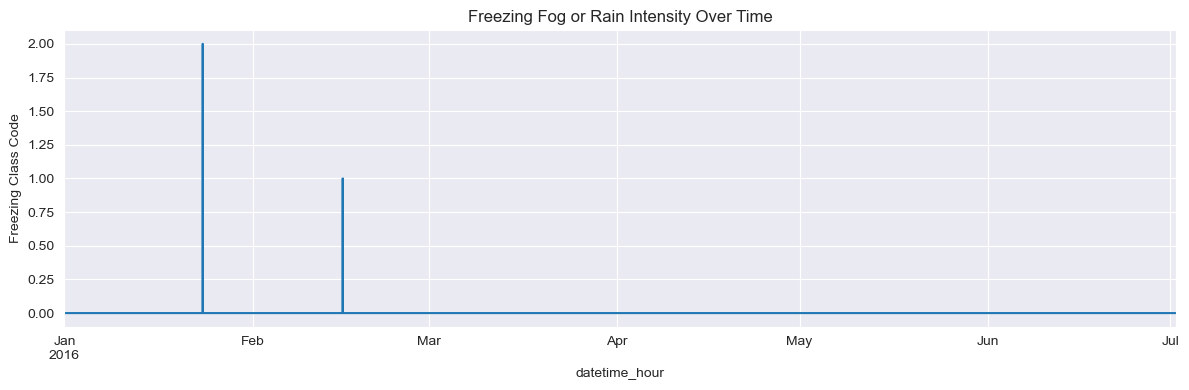

In [67]:
# Time series: Freezing Class Code
plt.figure(figsize=(12, 4))
weather_data.set_index('datetime_hour')['freezing_code'].plot(drawstyle='steps-post')
plt.title("Freezing Fog or Rain Intensity Over Time")
plt.ylabel("Freezing Class Code")
plt.grid(True)
plt.tight_layout()
plt.show()

## Classify / EDA –  fog

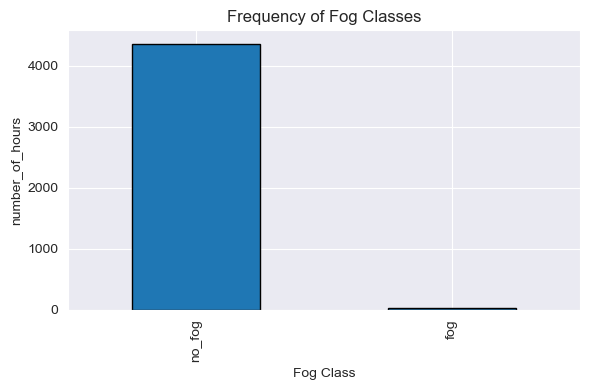

In [68]:
# Bar plot: Frequency of Fog Classes
fog_counts = weather_data['fog_class'].value_counts().reindex(["no_fog", "fog"])
fog_counts.plot(kind='bar', edgecolor='black', figsize=(6, 4))
plt.title("Frequency of Fog Classes")
plt.xlabel("Fog Class")
plt.ylabel('number_of_hours')
plt.grid(True)
plt.tight_layout()
plt.show()

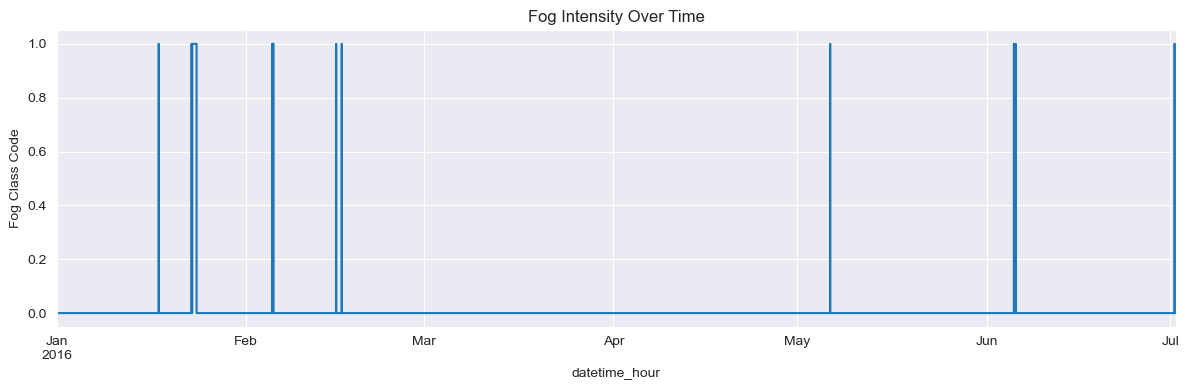

In [69]:
# Time series: Fog Class Code
plt.figure(figsize=(12, 4))
weather_data.set_index('datetime_hour')['fog_code'].plot(drawstyle='steps-post')
plt.title("Fog Intensity Over Time")
plt.ylabel("Fog Class Code")
plt.grid(True)
plt.tight_layout()
plt.show()

## Classify / EDA –  temp itensity

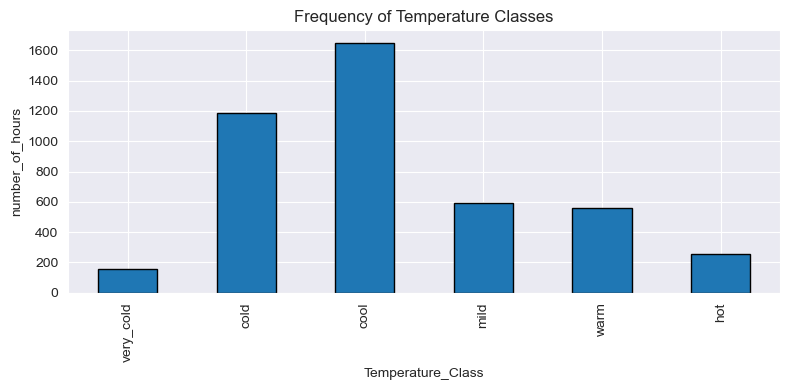

In [70]:
# Bar plot: Frequency of Temperature Classes
temp_counts = weather_data['temp_class'].value_counts().reindex([
  'very_cold', "cold", "cool", "mild", "warm", "hot"
])

temp_counts.plot(kind='bar', edgecolor='black', figsize=(8, 4))
plt.title("Frequency of Temperature Classes")
plt.xlabel('Temperature_Class')
plt.ylabel('number_of_hours')
plt.grid(True)
plt.tight_layout()
plt.show()

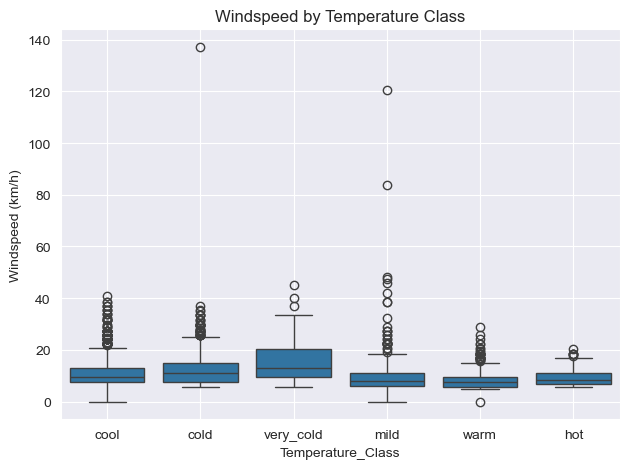

In [71]:
# Boxplot: Windspeed by Temperature Class
sns.boxplot(data=weather_data, x='temp_class', y='windspeed_kph')
plt.title("Windspeed by Temperature Class")
plt.xlabel('Temperature_Class')
plt.ylabel("Windspeed (km/h)")
plt.grid(True)
plt.tight_layout()
plt.show()

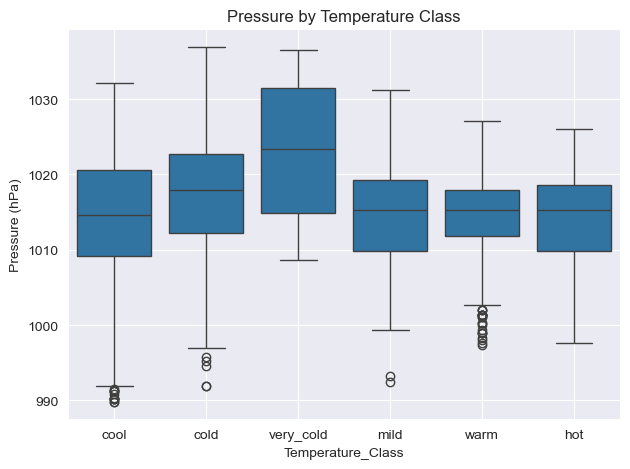

In [72]:
# Boxplot: Pressure by Temperature Class
sns.boxplot(data=weather_data, x='temp_class', y='pressure_hPa')
plt.title("Pressure by Temperature Class")
plt.xlabel('Temperature_Class')
plt.ylabel("Pressure (hPa)")
plt.grid(True)
plt.tight_layout()
plt.show()

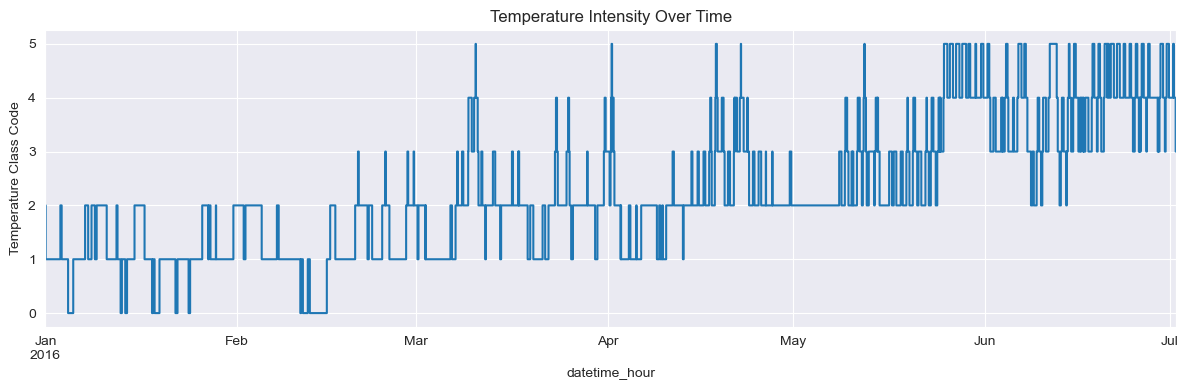

In [73]:
# Time series: Temperature Class Code over Time
plt.figure(figsize=(12, 4))
weather_data.set_index('datetime_hour')['temp_code'].plot(drawstyle='steps-post')
plt.title("Temperature Intensity Over Time")
plt.ylabel("Temperature Class Code")
plt.grid(True)
plt.tight_layout()
plt.show()

## Classify / EDA –  windspeed itensity

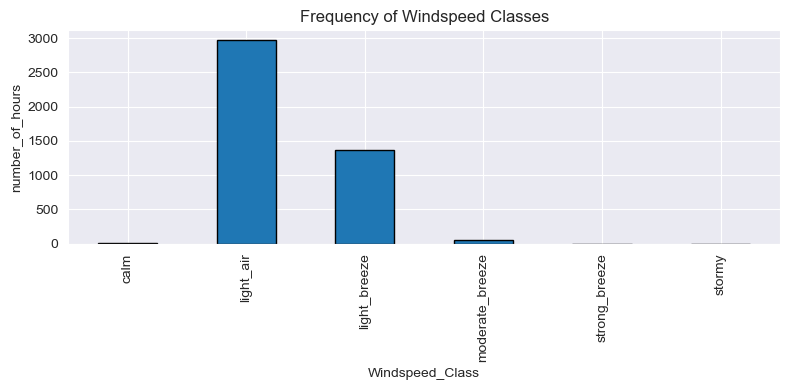

In [74]:
# Bar plot: Frequency of Windspeed Classes
windspeed_counts = weather_data['windspeed_class'].value_counts().reindex([
  "calm", 'light_air', 'light_breeze', 'moderate_breeze', 'strong_breeze', "stormy"
])

windspeed_counts.plot(kind='bar', edgecolor='black', figsize=(8, 4))
plt.title("Frequency of Windspeed Classes")
plt.xlabel('Windspeed_Class')
plt.ylabel('number_of_hours')
plt.grid(True)
plt.tight_layout()
plt.show()

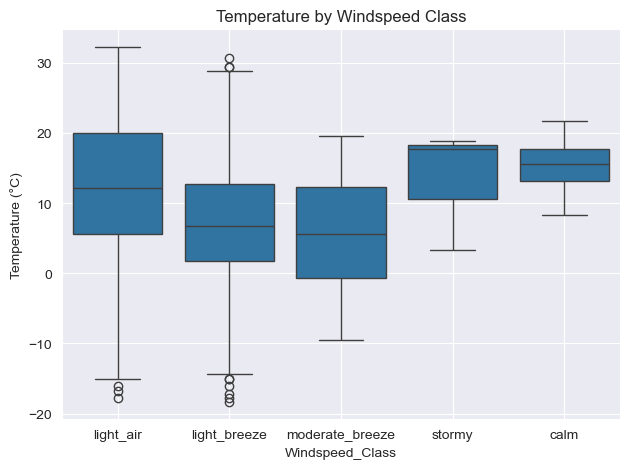

In [75]:
# Boxplot: Temperature by Windspeed Class
sns.boxplot(data=weather_data, x='windspeed_class', y='temp_c')
plt.title("Temperature by Windspeed Class")
plt.xlabel('Windspeed_Class')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.tight_layout()
plt.show()

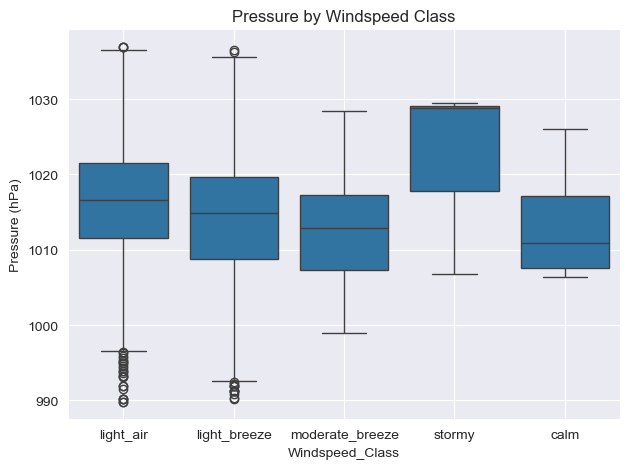

In [76]:
# Boxplot: Pressure by Windspeed Class
sns.boxplot(data=weather_data, x='windspeed_class', y='pressure_hPa')
plt.title("Pressure by Windspeed Class")
plt.xlabel('Windspeed_Class')
plt.ylabel("Pressure (hPa)")
plt.grid(True)
plt.tight_layout()
plt.show()

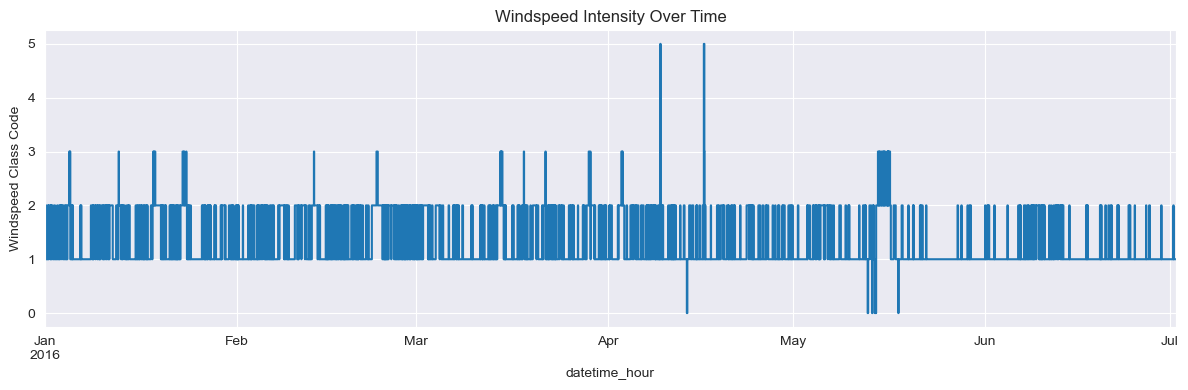

In [77]:
# Time series: Windspeed Class Code over Time
plt.figure(figsize=(12, 4))
weather_data.set_index('datetime_hour')['windspeed_code'].plot(drawstyle='steps-post')
plt.title("Windspeed Intensity Over Time")
plt.ylabel("Windspeed Class Code")
plt.grid(True)
plt.tight_layout()
plt.show()

## Classify / EDA –  humidity itensity

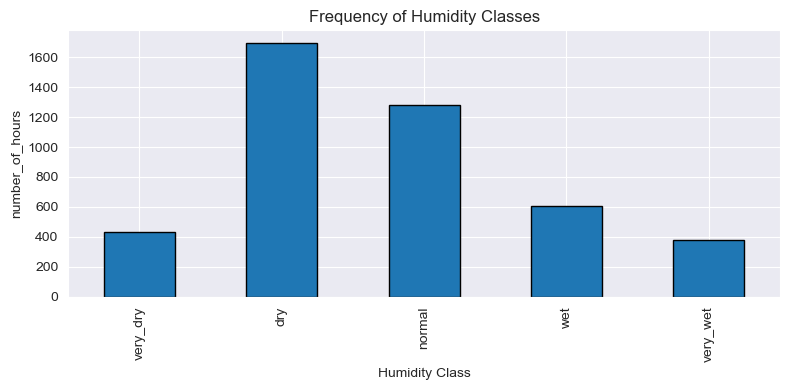

In [78]:
# Bar plot: Frequency of Humidity Classes
humidity_counts = weather_data['humidity_class'].value_counts().reindex([
  'very_dry', 'dry', 'normal', 'wet', 'very_wet'
])

humidity_counts.plot(kind='bar', edgecolor='black', figsize=(8, 4))
plt.title("Frequency of Humidity Classes")
plt.xlabel("Humidity Class")
plt.ylabel('number_of_hours')
plt.grid(True)
plt.tight_layout()
plt.show()

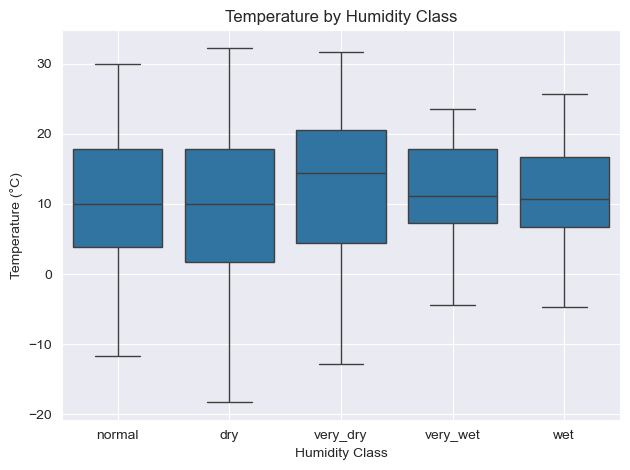

In [79]:

# Boxplot: Temperature by Humidity Class
sns.boxplot(data=weather_data, x='humidity_class', y='temp_c')
plt.title("Temperature by Humidity Class")
plt.xlabel("Humidity Class")
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.tight_layout()
plt.show()

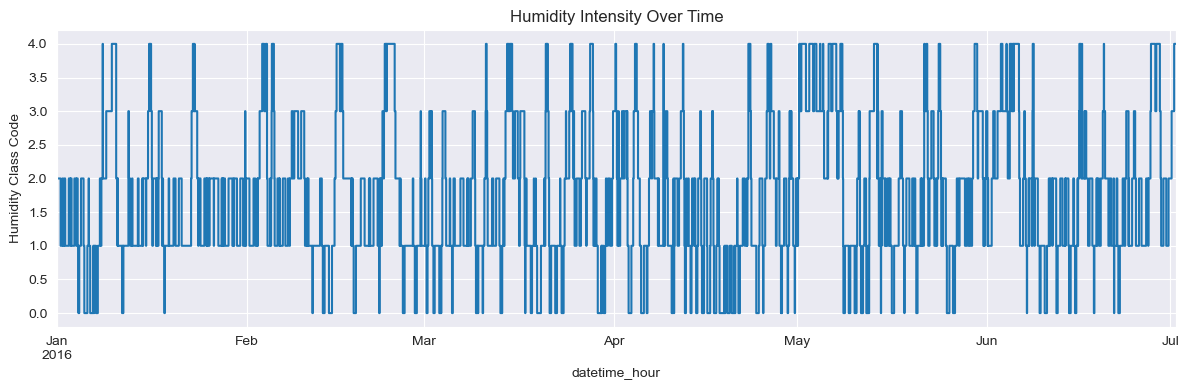

In [80]:

# Time series: Humidity Class Code over Time
plt.figure(figsize=(12, 4))
weather_data.set_index('datetime_hour')['humidity_code'].plot(drawstyle='steps-post')
plt.title("Humidity Intensity Over Time")
plt.ylabel("Humidity Class Code")
plt.grid(True)
plt.tight_layout()
plt.show()

## Classify / EDA –  pressure itensity

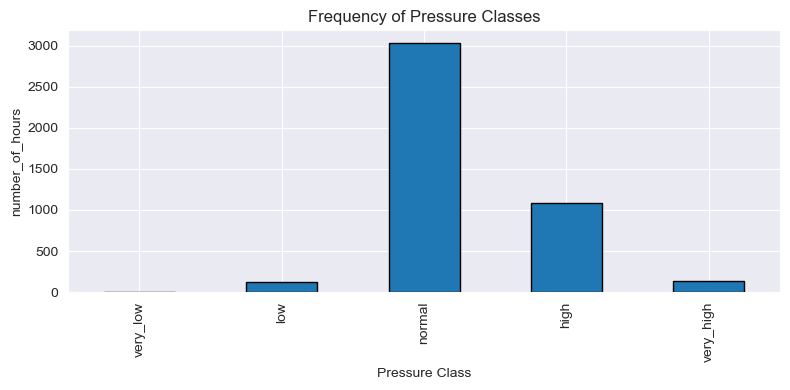

In [81]:
# Bar plot: Frequency of Pressure Classes
pressure_counts = weather_data['pressure_class'].value_counts().reindex([
  'very_low', "low", "normal", "high", 'very_high'
])

pressure_counts.plot(kind='bar', edgecolor='black', figsize=(8, 4))
plt.title("Frequency of Pressure Classes")
plt.xlabel("Pressure Class")
plt.ylabel('number_of_hours')
plt.grid(True)
plt.tight_layout()
plt.show()

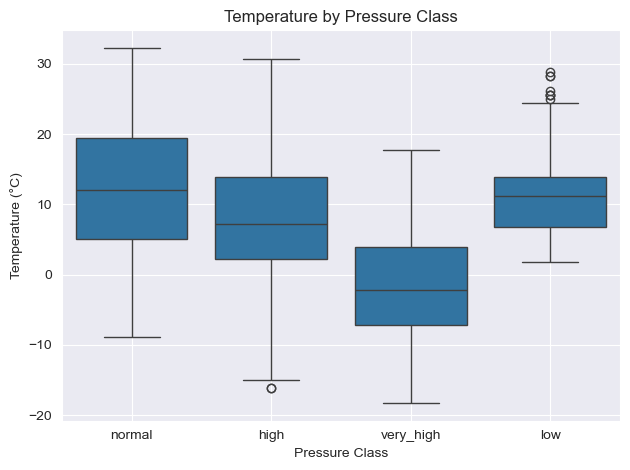

In [82]:
# Boxplot: Temperature by Pressure Class
sns.boxplot(data=weather_data, x='pressure_class', y='temp_c')
plt.title("Temperature by Pressure Class")
plt.xlabel("Pressure Class")
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.tight_layout()
plt.show()

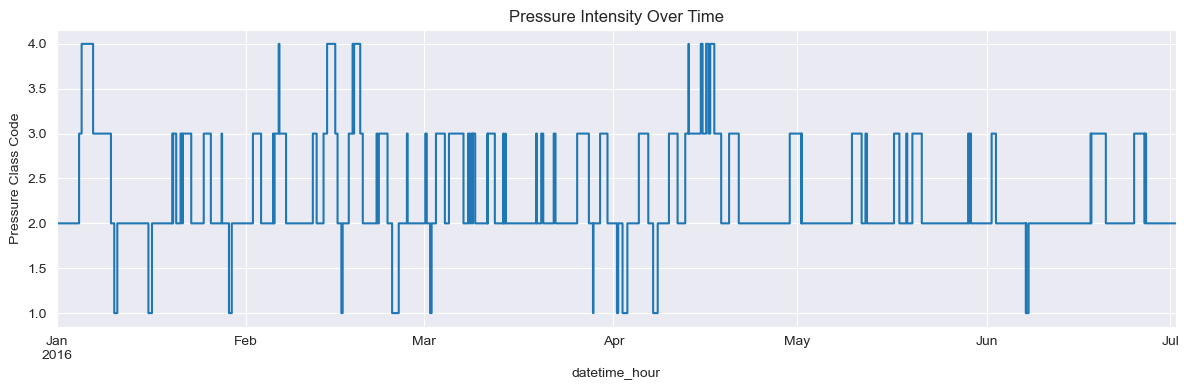

In [83]:

# Time series: Pressure Class Code over Time
plt.figure(figsize=(12, 4))
weather_data.set_index('datetime_hour')['pressure_code'].plot(drawstyle='steps-post')
plt.title("Pressure Intensity Over Time")
plt.ylabel("Pressure Class Code")
plt.grid(True)
plt.tight_layout()
plt.show()

# Save Weather Data

In [84]:
weather_data.isna().sum()

datetime_hour      0
humidity           0
fog                0
rain               0
snow               0
conditions         0
datetime           0
hour_of_day        0
hour_of_year       0
temp_c             0
windspeed_kph      0
precip_mm          0
pressure_hPa       0
precip_daily_mm    0
daily_snow_mm      0
rain_class         0
rain_code          0
snow_class         0
snow_code          0
cloud_class        0
cloud_code         0
hazy_class         0
hazy_code          0
freezing_class     0
freezing_code      0
fog_class          0
fog_code           0
temp_class         0
temp_code          0
windspeed_class    0
windspeed_code     0
humidity_class     0
humidity_code      0
pressure_class     0
pressure_code      0
dtype: int64

In [85]:
weather_data_raw_copy.to_csv(WEATHER_RAW_PATH, index=False)

In [86]:
weather_data.to_csv(WEATHER_PATH, index=False)